In [2]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PATHS
base_dir = "../input/dog-disease/dog"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")

# TRANSFORMS
img_size = 224
transform = {
    "train": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "valid": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# DATASETS
train_dataset = ImageFolder(train_dir, transform=transform["train"])
valid_dataset = ImageFolder(valid_dir, transform=transform["valid"])
test_dataset  = ImageFolder(test_dir,  transform=transform["valid"])

# DATALOADERS
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# MODEL
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # 3 classes
model = model.to(device)

# LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# TRAINING LOOP
def train_model(model, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        val_acc = evaluate_model(model, valid_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader.dataset):.4f}, Train Acc: {100*correct/total:.2f}%, Val Acc: {val_acc:.2f}%")

# EVALUATION
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# RUN
train_model(model, epochs=5)

# TEST SET PERFORMANCE
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

# SAVE MODEL
torch.save(model.state_dict(), "dog_disease_model.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


Epoch 1/5, Loss: 0.1107, Train Acc: 96.05%, Val Acc: 98.93%
Epoch 2/5, Loss: 0.0168, Train Acc: 99.59%, Val Acc: 99.08%
Epoch 3/5, Loss: 0.0088, Train Acc: 99.81%, Val Acc: 99.46%
Epoch 4/5, Loss: 0.0095, Train Acc: 99.68%, Val Acc: 99.16%
Epoch 5/5, Loss: 0.0122, Train Acc: 99.68%, Val Acc: 98.00%
Test Accuracy: 97.74%


In [4]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 0.1066, Train Acc: 96.39%, Val Acc: 99.16%
Epoch 2/10, Train Loss: 0.0182, Train Acc: 99.48%, Val Acc: 99.54%
Epoch 3/10, Train Loss: 0.0078, Train Acc: 99.87%, Val Acc: 99.54%
Epoch 4/10, Train Loss: 0.0064, Train Acc: 99.89%, Val Acc: 99.16%
Epoch 5/10, Train Loss: 0.0065, Train Acc: 99.87%, Val Acc: 99.23%
Epoch 6/10, Train Loss: 0.0041, Train Acc: 99.91%, Val Acc: 99.31%
Epoch 7/10, Train Loss: 0.0049, Train Acc: 99.87%, Val Acc: 99.69%
Epoch 8/10, Train Loss: 0.0072, Train Acc: 99.81%, Val Acc: 99.00%
Epoch 9/10, Train Loss: 0.0090, Train Acc: 99.74%, Val Acc: 99.46%
Epoch 10/10, Train Loss: 0.0086, Train Acc: 99.76%, Val Acc: 99.46%

Test Accuracy: 99.70% | Test Loss: 0.0155


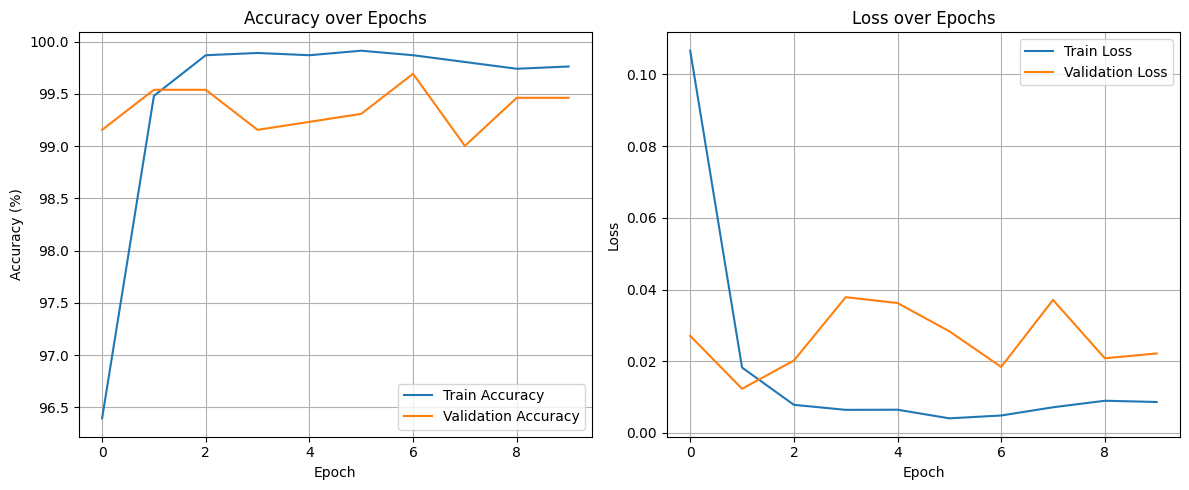


🔍 Inference on unseen image + Grad-CAM XAI


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_31/1868085657.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

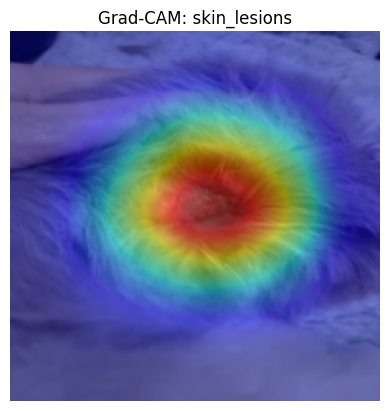

🧠 Predicted Class: skin_lesions


In [5]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from PIL import Image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import torchvision.transforms.functional as F

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PATHS
base_dir = "../input/dog-disease/dog"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")

# TRANSFORMS
img_size = 224
transform = {
    "train": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "valid": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# DATASETS
train_dataset = ImageFolder(train_dir, transform=transform["train"])
valid_dataset = ImageFolder(valid_dir, transform=transform["valid"])
test_dataset  = ImageFolder(test_dir,  transform=transform["valid"])
class_names = train_dataset.classes

# DATALOADERS
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# MODEL
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# METRICS STORAGE
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

# EVALUATION FUNCTION
def evaluate_model(model, loader):
    model.eval()
    correct, total, loss_total = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss_total += loss.item() * inputs.size(0)
    return 100 * correct / total, loss_total / total

# TRAINING LOOP
def train_model(model, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_loss = running_loss / total
        val_acc, val_loss = evaluate_model(model, valid_loader)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# RUN TRAINING
train_model(model, epochs=10)

# FINAL TEST ACCURACY
test_acc, test_loss = evaluate_model(model, test_loader)
print(f"\nTest Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")

# SAVE MODEL
torch.save(model.state_dict(), "dog_disease_model.pth")

# 📊 PLOT LOSS & ACCURACY
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 🧪 INFERENCE ON UNSEEN IMAGE + XAI
print("\n🔍 Inference on unseen image + Grad-CAM XAI")

# Load model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load("dog_disease_model.pth"))
model.to(device)
model.eval()

# Grad-CAM setup
cam_extractor = GradCAM(model, target_layer="layer4")

# Unseen image
img_path = "/kaggle/input/skindog/skin_lesions_00000005_jpg.rf.2991e7351b06cf15dbb4dcf031c4d9b0.jpg"  # <-- Change this
img = Image.open(img_path).convert("RGB")

# Preprocess
test_transform = transform["valid"]
img_tensor = test_transform(img).unsqueeze(0).to(device)
img_tensor.requires_grad_()

# Inference
output = model(img_tensor)
pred_class = output.argmax(dim=1).item()
activation_map = cam_extractor(pred_class, output)

# Denormalize for visualization
input_tensor = img_tensor.squeeze().cpu()
input_image = F.to_pil_image(input_tensor * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) +
                              torch.tensor([0.485, 0.456, 0.406]).view(3,1,1))

# Overlay Grad-CAM
result = overlay_mask(input_image, F.to_pil_image(activation_map[0], mode='F'), alpha=0.5)
plt.imshow(result)
plt.title(f"Grad-CAM: {class_names[pred_class]}")
plt.axis('off')
plt.show()

print(f"🧠 Predicted Class: {class_names[pred_class]}")
